# (13) OOD — src: Omniglot

**Motivation**: host = ```Mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 3
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:3  ———  host: mach

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from analysis.ood import *

## Poisson, MLP decoder

In [4]:
models2load = {
    'iterative': dict(
        model_name='poisson_Omniglot_t-32_z-[128]_<jacob|mlp>',
        fit_name='b200-ep1000-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,16:10)',
        device=device,
        shuffle=False,
    ),
    'amortized': dict(
        model_name='poisson_Omniglot_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep1000-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,16:33)',
        device=device,
        shuffle=False,
    )
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['iterative']

100%|█████████████████████████████████| 66/66 [03:22<00:00,  3.07s/it]


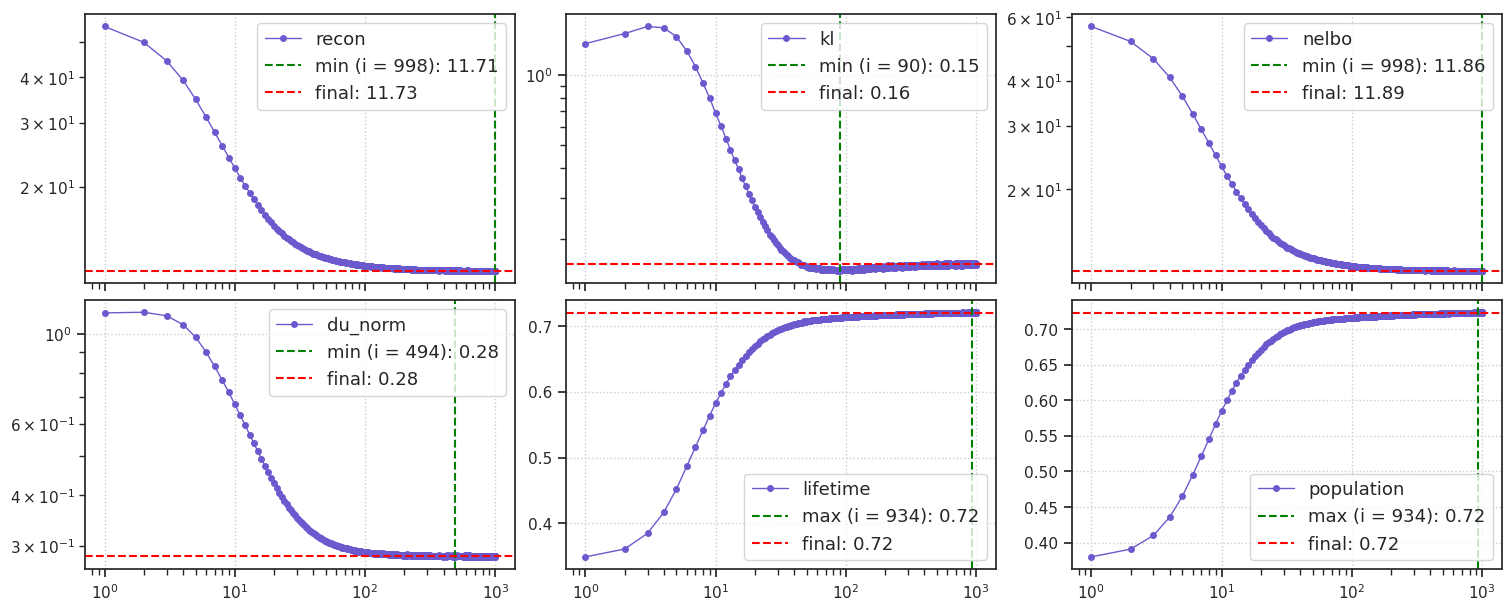

In [6]:
results = tr.analysis('vld', seq_total=1000)
_ = plot_convergence(results, color='slateblue')

In [7]:
list(tr.stats['grad'])[-1], tr.model.cfg.init_scale

(95999, 0.05)

### MNIST

#### iterative

In [8]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['iterative'],
    dataset='MNIST',
    t_decay=int(1e5),
)

CPU times: user 26min 59s, sys: 2min 4s, total: 29min 4s
Wall time: 8min 25s


In [9]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      10.93
clf accuracy:   0.937

In [10]:
order = np.argsort(powers)
(~np.isfinite(powers)).sum()

0

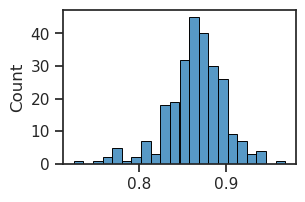

In [11]:
sns.histplot(powers, edgecolor='k');

In [12]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

In [13]:
print(sp_stats.pearsonr(powers, results_decay['recon'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['nelbo'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['kl'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['du_norm'][:, -1]))

PearsonRResult(statistic=-0.5687417496118254, pvalue=2.439991160026604e-23)

PearsonRResult(statistic=-0.5684914773282621, pvalue=2.5749808755512223e-23)

PearsonRResult(statistic=-0.33346208691138374, pvalue=4.588901903655669e-08)

PearsonRResult(statistic=-0.3808297827629404, pvalue=2.9278929437803167e-10)

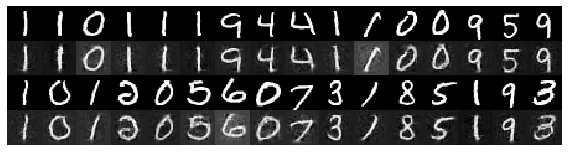

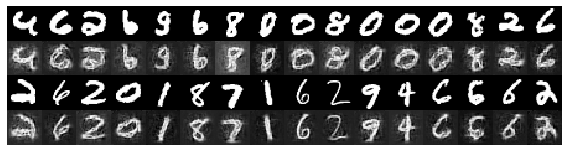

In [14]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

In [15]:
control = results_decay['recon'][order[-16:]].mean(0)
challenge = results_decay['recon'][order[:16]].mean(0)

mode = 'powerlaw'

params_control = fit_decay(control, mode=mode)
params_challenge = fit_decay(challenge, mode=mode)

print(params_control)
print(params_challenge)

[54.37292316  0.9261677   5.60197958]

[98.46430204  0.78146861 23.66318311]

In [16]:
times = np.arange(len(control))
if mode == 'powerlaw':
    times += 1

f = exp_decay if mode == 'exp' else powerlaw_decay
fit_control = f(times, *params_control)
fit_challenge = f(times, *params_challenge)

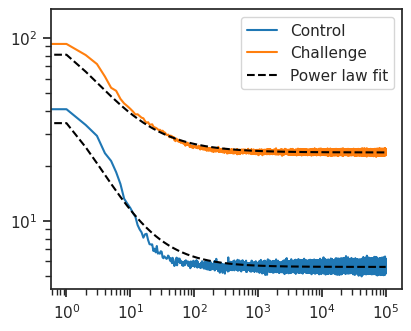

In [17]:
fig, ax = create_figure(1, 1, (4, 3.2))
ax.loglog(control, color='C0', label='Control')
ax.loglog(fit_control, color='k', ls='--')

ax.loglog(challenge, color='C1', label='Challenge')
ax.loglog(fit_challenge, color='k', label='Power law fit', ls='--')

add_legend(ax)
plt.show()

#### amortized

In [18]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['amortized'],
    dataset='MNIST',
)

CPU times: user 50.1 s, sys: 2.06 s, total: 52.2 s
Wall time: 2.06 s


In [19]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      49.02
clf accuracy:   0.934

In [20]:
order = np.argsort(results_decay['recon'][:, -1])[::-1]

In [21]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

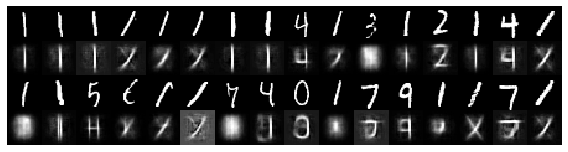

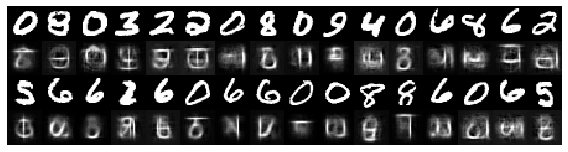

In [22]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

### EMNIST

#### iterative

In [23]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['iterative'],
    dataset='EMNIST',
    t_decay=int(1e5),
)

CPU times: user 26min 23s, sys: 2min 6s, total: 28min 29s
Wall time: 9min 4s


In [24]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      14.68
clf accuracy:   0.740

In [25]:
order = np.argsort(powers)
(~np.isfinite(powers)).sum()

0

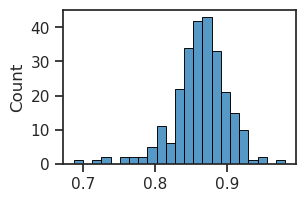

In [26]:
sns.histplot(powers, edgecolor='k');

In [27]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

In [28]:
print(sp_stats.pearsonr(powers, results_decay['recon'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['nelbo'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['kl'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['du_norm'][:, -1]))

PearsonRResult(statistic=-0.5160717867446022, pvalue=7.950981941245763e-19)

PearsonRResult(statistic=-0.5169190695411461, pvalue=6.821674012013443e-19)

PearsonRResult(statistic=-0.36186301514763586, pvalue=2.448783267206191e-09)

PearsonRResult(statistic=-0.35758218507819295, pvalue=3.881139504270772e-09)

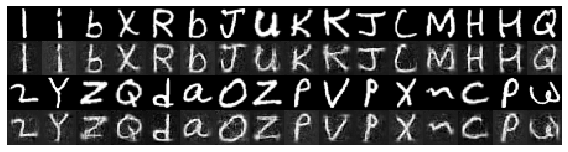

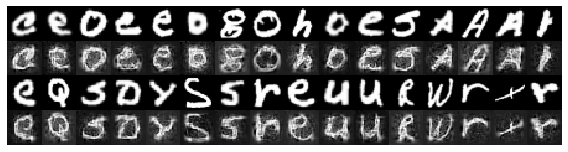

In [29]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

In [30]:
control = results_decay['recon'][order[-16:]].mean(0)
challenge = results_decay['recon'][order[:16]].mean(0)

mode = 'powerlaw'

params_control = fit_decay(control, mode=mode)
params_challenge = fit_decay(challenge, mode=mode)

print(params_control)
print(params_challenge)

[74.96718792  0.92536349 10.83075756]

[106.12675796   0.76740167  24.650356  ]

In [31]:
times = np.arange(len(control))
if mode == 'powerlaw':
    times += 1

f = exp_decay if mode == 'exp' else powerlaw_decay
fit_control = f(times, *params_control)
fit_challenge = f(times, *params_challenge)

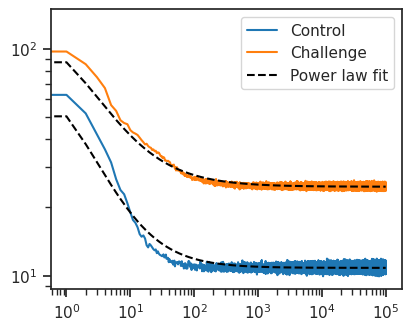

In [33]:
fig, ax = create_figure(1, 1, (4, 3.2))
ax.loglog(control, color='C0', label='Control')
ax.loglog(fit_control, color='k', ls='--')

ax.loglog(challenge, color='C1', label='Challenge')
ax.loglog(fit_challenge, color='k', label='Power law fit', ls='--')

add_legend(ax)
plt.show()

#### amortized

In [34]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['amortized'],
    dataset='EMNIST',
)

CPU times: user 1min 1s, sys: 2.24 s, total: 1min 3s
Wall time: 3.31 s


In [35]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      61.44
clf accuracy:   0.727

In [36]:
order = np.argsort(results_decay['recon'][:, -1])[::-1]

In [37]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

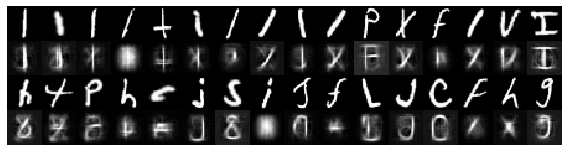

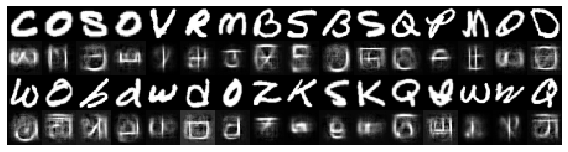

In [38]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

## Poisson, lineaer decoder

In [4]:
models2load = {
    'iterative': dict(
        model_name='poisson_Omniglot_t-32_z-[512]_<jacob|lin>',
        fit_name='b200-ep1000-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,11:28)',
        device=device,
        shuffle=False,
    ),
    'amortized': dict(
        model_name='poisson_Omniglot_t-1_z-[512]_<lin|lin>',
        fit_name='b200-ep1000-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,16:07)',
        device=device,
        shuffle=False,
    )
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['iterative']

100%|█████████████████████████████████| 66/66 [04:04<00:00,  3.70s/it]


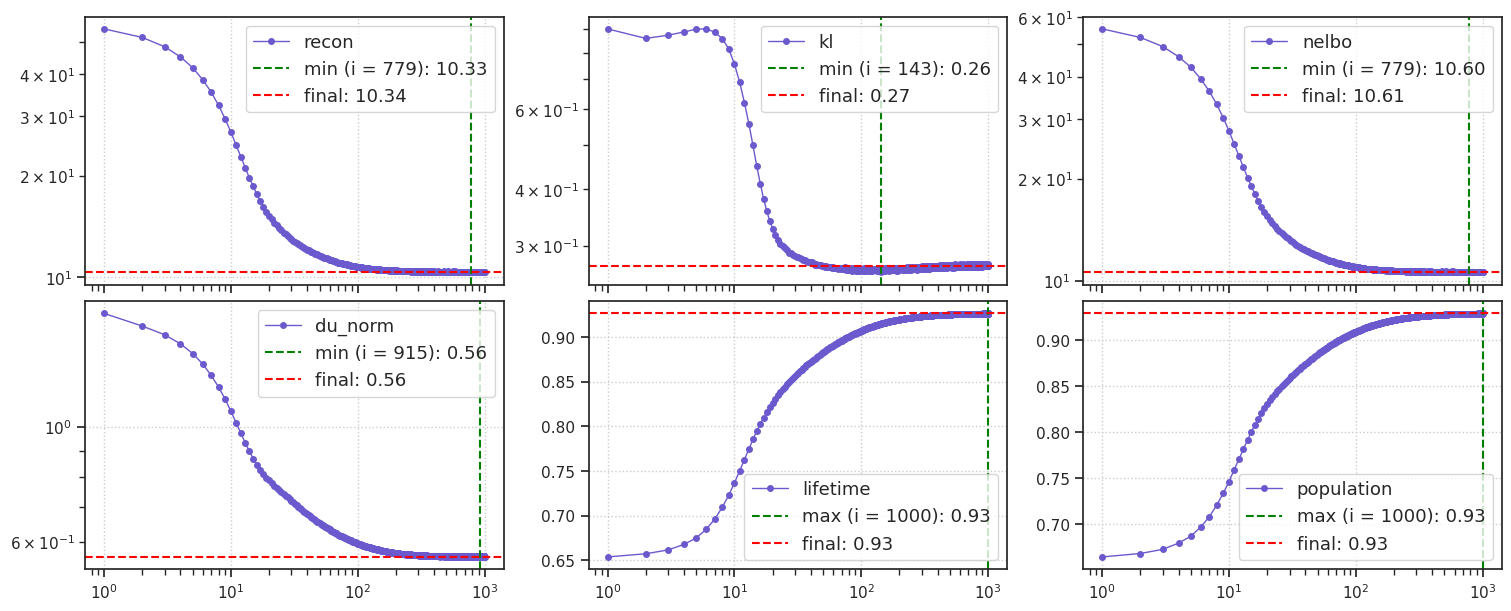

In [6]:
results = tr.analysis('vld', seq_total=1000)
_ = plot_convergence(results, color='slateblue')

### MNIST

#### iterative

In [7]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['iterative'],
    dataset='MNIST',
    t_decay=int(1e5),
)

CPU times: user 28min 31s, sys: 2min 50s, total: 31min 21s
Wall time: 10min 7s


In [8]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      9.45
clf accuracy:   0.976

In [9]:
order = np.argsort(powers)
(~np.isfinite(powers)).sum()

0

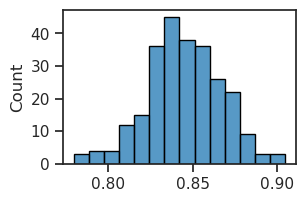

In [10]:
sns.histplot(powers, edgecolor='k');

In [11]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

In [12]:
print(sp_stats.pearsonr(powers, results_decay['recon'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['nelbo'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['kl'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['du_norm'][:, -1]))

PearsonRResult(statistic=0.2664577628289198, pvalue=1.554419950560172e-05)

PearsonRResult(statistic=0.2737878633636368, pvalue=8.814521897192052e-06)

PearsonRResult(statistic=0.2871324397900714, pvalue=3.006821646759645e-06)

PearsonRResult(statistic=0.23946415908866903, pvalue=0.00010922940314300663)

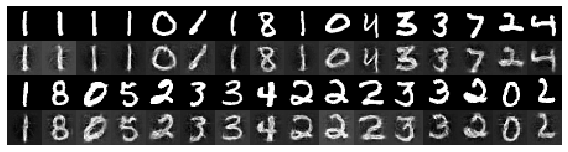

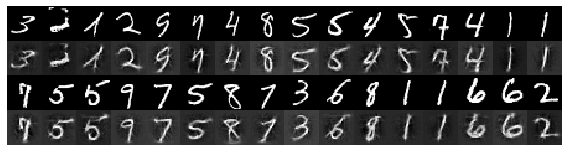

In [13]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

In [14]:
control = results_decay['recon'][order[-16:]].mean(0)
challenge = results_decay['recon'][order[:16]].mean(0)

mode = 'powerlaw'

params_control = fit_decay(control, mode=mode)
params_challenge = fit_decay(challenge, mode=mode)

print(params_control)
print(params_challenge)

[71.69049898  0.88509448  8.56917041]

[44.75269876  0.79837032  6.69484951]

In [15]:
times = np.arange(len(control))
if mode == 'powerlaw':
    times += 1

f = exp_decay if mode == 'exp' else powerlaw_decay
fit_control = f(times, *params_control)
fit_challenge = f(times, *params_challenge)

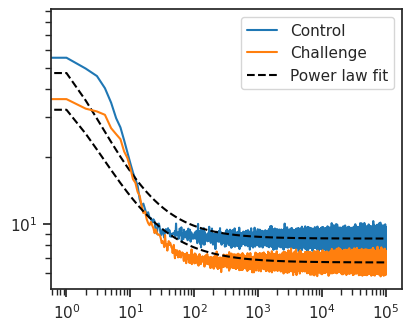

In [16]:
fig, ax = create_figure(1, 1, (4, 3.2))
ax.loglog(control, color='C0', label='Control')
ax.loglog(fit_control, color='k', ls='--')

ax.loglog(challenge, color='C1', label='Challenge')
ax.loglog(fit_challenge, color='k', label='Power law fit', ls='--')

add_legend(ax)
plt.show()

#### amortized

In [17]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['amortized'],
    dataset='MNIST',
)

CPU times: user 1min 21s, sys: 1.86 s, total: 1min 23s
Wall time: 2.05 s


In [18]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      44.17
clf accuracy:   0.957

In [19]:
order = np.argsort(results_decay['recon'][:, -1])[::-1]

In [20]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

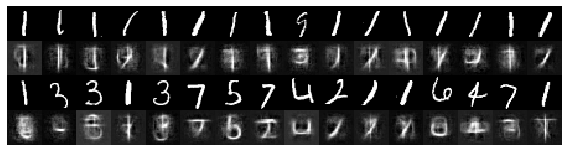

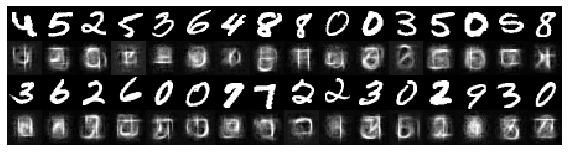

In [21]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

### EMNIST

#### iterative

In [22]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['iterative'],
    dataset='EMNIST',
    t_decay=int(1e5),
)

CPU times: user 33min 11s, sys: 2min 53s, total: 36min 4s
Wall time: 10min 24s


In [23]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      11.45
clf accuracy:   0.868

In [24]:
order = np.argsort(powers)
(~np.isfinite(powers)).sum()

0

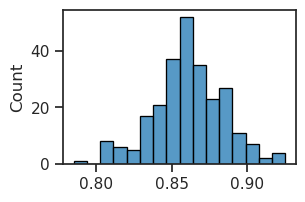

In [25]:
sns.histplot(powers, edgecolor='k');

In [26]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

In [27]:
print(sp_stats.pearsonr(powers, results_decay['recon'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['nelbo'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['kl'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['du_norm'][:, -1]))

PearsonRResult(statistic=0.08818829740161747, pvalue=0.159471881013786)

PearsonRResult(statistic=0.10235613608926673, pvalue=0.10226350401541653)

PearsonRResult(statistic=0.2678950227715826, pvalue=1.392592688543183e-05)

PearsonRResult(statistic=0.18194204388007262, pvalue=0.0034863271325767703)

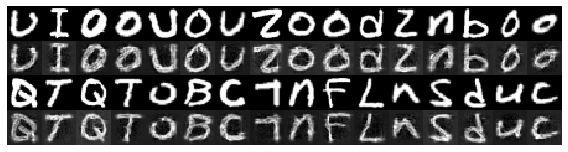

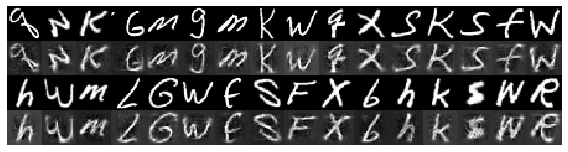

In [28]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

In [29]:
control = results_decay['recon'][order[-16:]].mean(0)
challenge = results_decay['recon'][order[:16]].mean(0)

mode = 'powerlaw'

params_control = fit_decay(control, mode=mode)
params_challenge = fit_decay(challenge, mode=mode)

print(params_control)
print(params_challenge)

[135.92367934   0.90754556  13.03217213]

[72.72336254  0.81128597 11.90669405]

In [30]:
times = np.arange(len(control))
if mode == 'powerlaw':
    times += 1

f = exp_decay if mode == 'exp' else powerlaw_decay
fit_control = f(times, *params_control)
fit_challenge = f(times, *params_challenge)

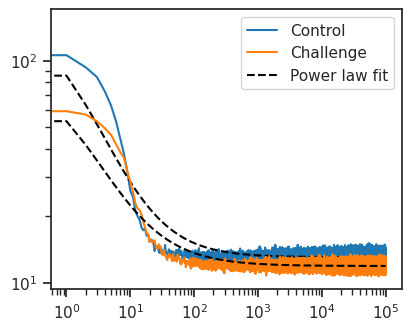

In [31]:
fig, ax = create_figure(1, 1, (4, 3.2))
ax.loglog(control, color='C0', label='Control')
ax.loglog(fit_control, color='k', ls='--')

ax.loglog(challenge, color='C1', label='Challenge')
ax.loglog(fit_challenge, color='k', label='Power law fit', ls='--')

add_legend(ax)
plt.show()

#### amortized

In [32]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['amortized'],
    dataset='EMNIST',
)

CPU times: user 3min 12s, sys: 2.72 s, total: 3min 15s
Wall time: 5.12 s


In [33]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      53.32
clf accuracy:   0.798

In [34]:
order = np.argsort(results_decay['recon'][:, -1])[::-1]

In [35]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

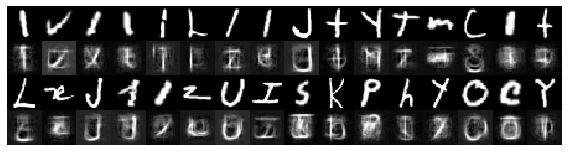

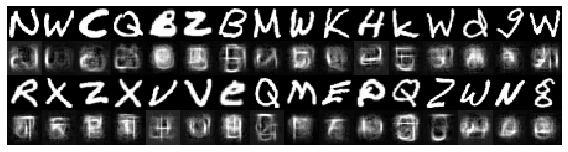

In [36]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)